In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import itertools
import sys
sys.path.insert(0, '..')
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 16
import numpy as np
import pandas as pd
import requests
import seaborn as sns
sns.set_style('whitegrid')

import covid19

## data

In [3]:
date_italy_regions_path = 'dpc-covid19-ita-regioni.csv'
# date_italy_regions_path = covid19.data.download('regioni')


In [4]:
data_italy_regions = pd.read_csv(date_italy_regions_path, parse_dates=['data'], index_col=['data'])
data_italy_regions['totale_terapia_intensiva'] = data_italy_regions['terapia_intensiva'] + data_italy_regions['deceduti']
data_italy_regions['totale_ricoverati'] = data_italy_regions['ricoverati_con_sintomi'] + data_italy_regions['totale_terapia_intensiva']

data_italy_regions.index = data_italy_regions.index.normalize()

data_italy_regions.loc[data_italy_regions.index.max()].sort_values('totale_ricoverati', ascending=False)[['denominazione_regione', 'totale_ricoverati']].head(15)


,denominazione_regione,totale_ricoverati
data,,
2020-03-11,Lombardia,5029
2020-03-11,Emilia Romagna,962
2020-03-11,Piemonte,415
2020-03-11,Veneto,359
2020-03-11,Marche,296
2020-03-11,Toscana,142
2020-03-11,Liguria,116
2020-03-11,Lazio,91
2020-03-11,Campania,68


In [5]:
regions = data_italy_regions['denominazione_regione'].unique().tolist()
print(regions)

['Abruzzo', 'Basilicata', 'P.A. Bolzano', 'Calabria', 'Campania', 'Emilia Romagna', 'Friuli Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche', 'Molise', 'Piemonte', 'Puglia', 'Sardegna', 'Sicilia', 'Toscana', 'P.A. Trento', 'Umbria', "Valle d'Aosta", 'Veneto']


## situation report

In [6]:
DAY = np.timedelta64(24 * 60 * 60,'s')

START_FIT = None
CHANGE_FIT_1 = np.datetime64('2020-03-06')
STOP_FIT = None

EXTRAPOLTATE = ('2020-02-23', '2020-03-12')

REGIONS_FIT_PARAMS = {
    'Lombardia': {},
    'Emilia Romagna': {
        'exponential_fits': [(None, '2020-03-01'), ('2020-03-02', '2020-03-05'), ('2020-03-06', None)]
    },
    'Veneto': {},
    'Piemonte': {
        'exponential_fits': [(None, '2020-03-08'), ('2020-03-08', None)]
    },
    'Marche': {
        'exponential_fits': [(None, '2020-03-05'), ('2020-03-06', None)]
    },
    'Toscana': {
        'exponential_fits': [(None, '2020-03-08'), ('2020-03-08', None)]
    },
    'Liguria': {
        'exponential_fits': [('2020-03-04', None)]
    },
    'Lazio':  {},
    'Campania': {
        'exponential_fits': [(None, None)]
    },
    'Puglia': {},
    'Abbruzzo': {},
    'Basilicata': {},
    'Calabria': {},
    'Friuli Venezia Giulia': {},
    'Molise': {},
    'Sardegna': {},
    'Sicilia': {},
    'Umbria': {},
    "Valle d'Aosta": {},
}
    
DELAY = 12 * DAY
PALETTE = itertools.cycle(sns.color_palette())

In [7]:
fits = {}
for region, params in REGIONS_FIT_PARAMS.items():
    for kind in ['totale_ricoverati']:
        exponential_fits = params.get('exponential_fits', [(START_FIT, CHANGE_FIT_1), (CHANGE_FIT_1 + DAY, STOP_FIT)])
        fits[region, kind] = []
        for start, stop in exponential_fits:
            try:
                select = (data_italy_regions['denominazione_regione'] == region) & (data_italy_regions[kind] >= 8)
                fits[region, kind] += [covid19.fit.ExponentialFit.from_frame(kind, data_italy_regions[select], start=start, stop=stop)]
            except:
                print('skipping:', region, start, stop)

skipping: Puglia None 2020-03-06
skipping: Abbruzzo None 2020-03-06
skipping: Abbruzzo 2020-03-07T00:00:00 None
skipping: Basilicata None 2020-03-06
skipping: Basilicata 2020-03-07T00:00:00 None
skipping: Calabria None 2020-03-06
skipping: Friuli Venezia Giulia None 2020-03-06
skipping: Molise None 2020-03-06
skipping: Molise 2020-03-07T00:00:00 None
skipping: Sardegna None 2020-03-06
skipping: Sicilia None 2020-03-06
skipping: Umbria None 2020-03-06
skipping: Valle d'Aosta None 2020-03-06
skipping: Valle d'Aosta 2020-03-07T00:00:00 None


No data for Abbruzzo
No data for Basilicata
No data for Molise
No data for Valle d'Aosta


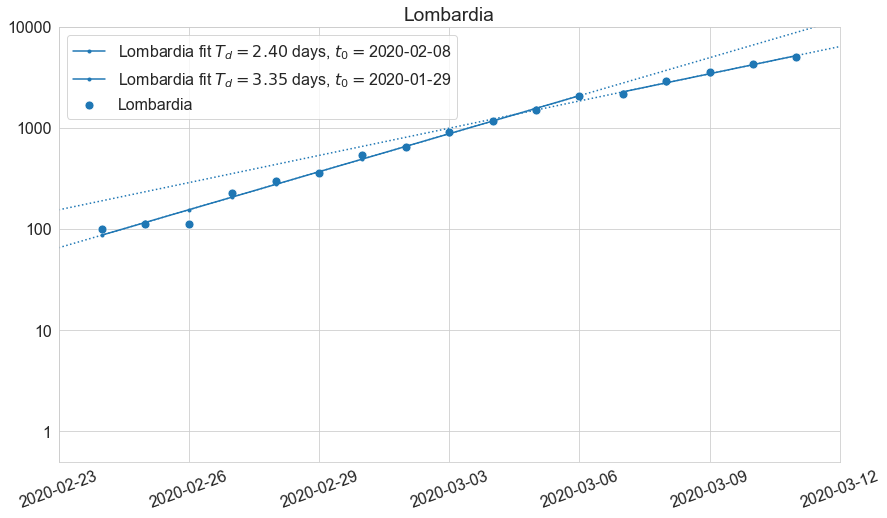

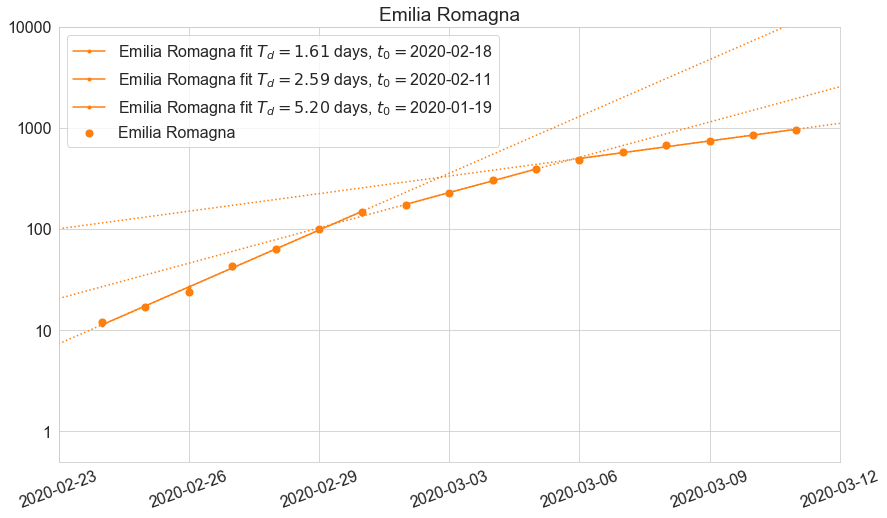

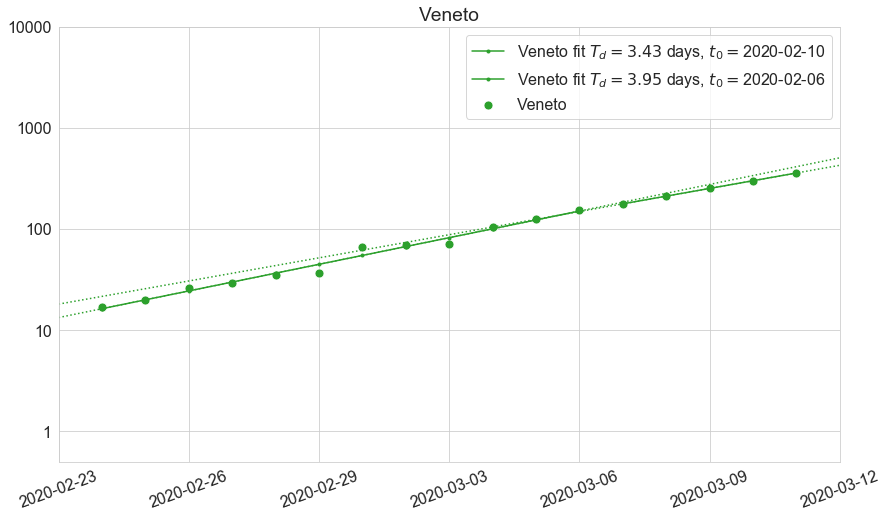

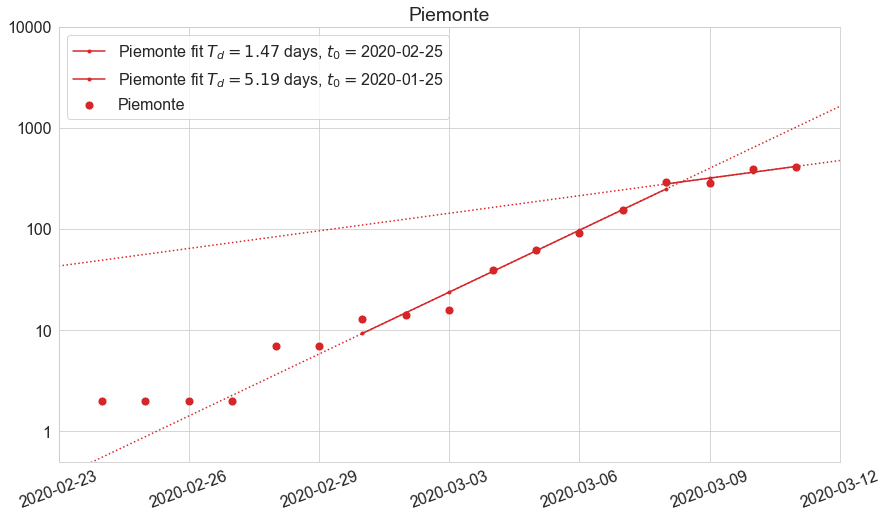

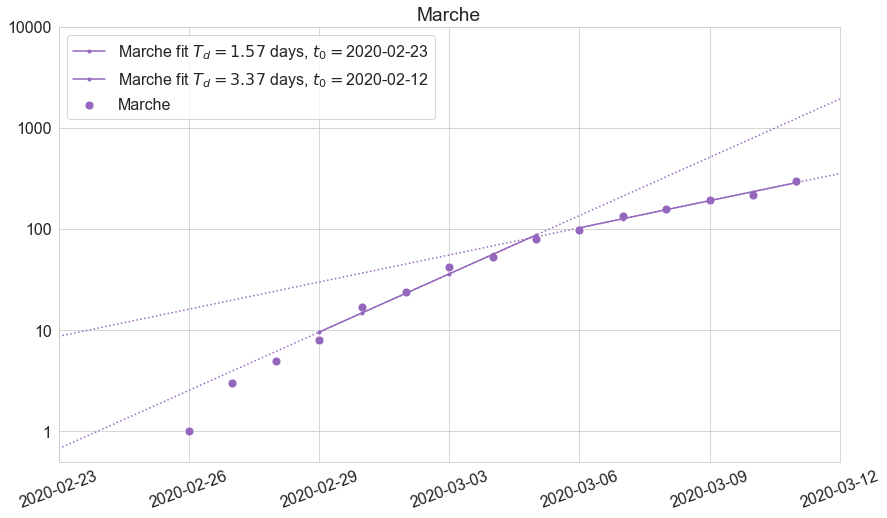

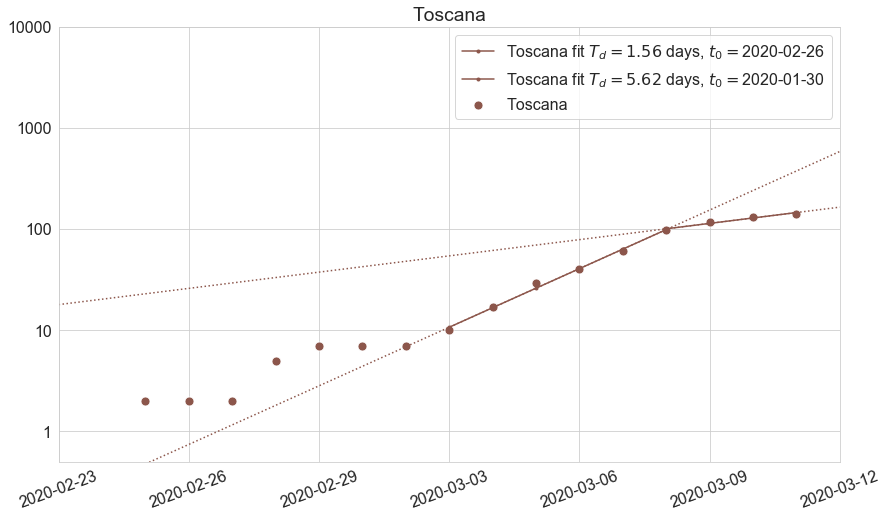

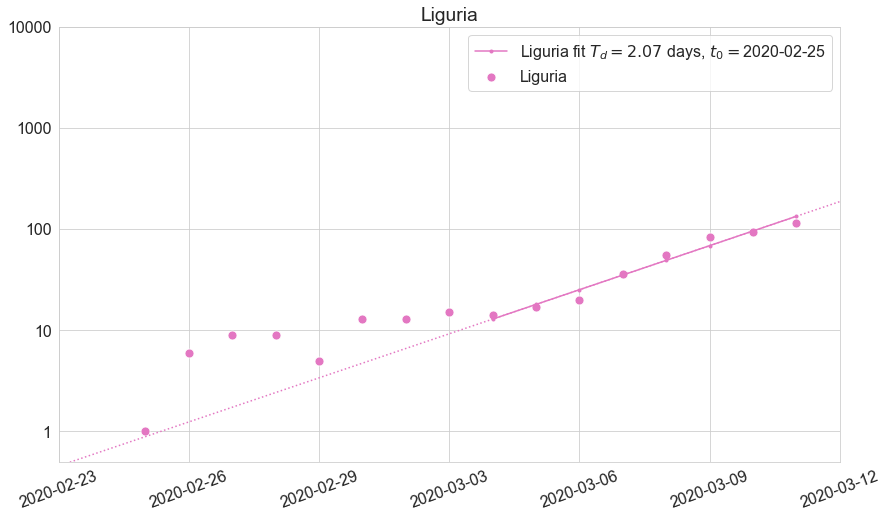

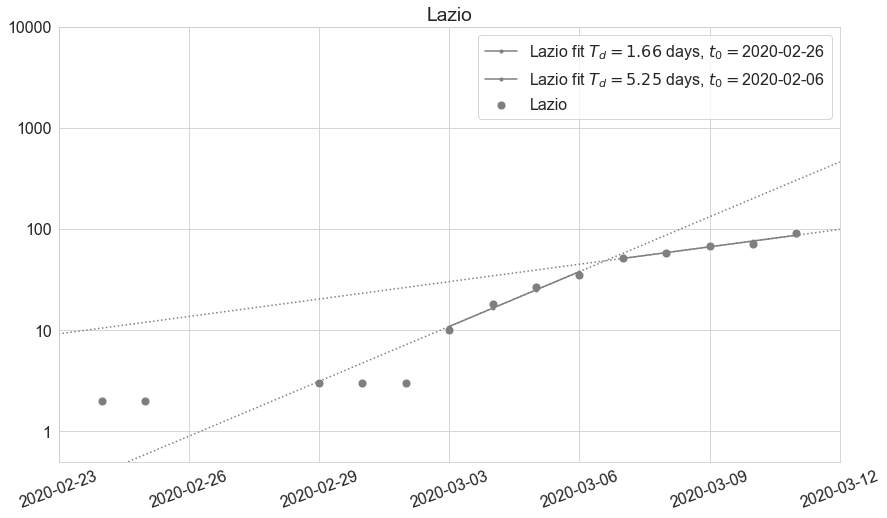

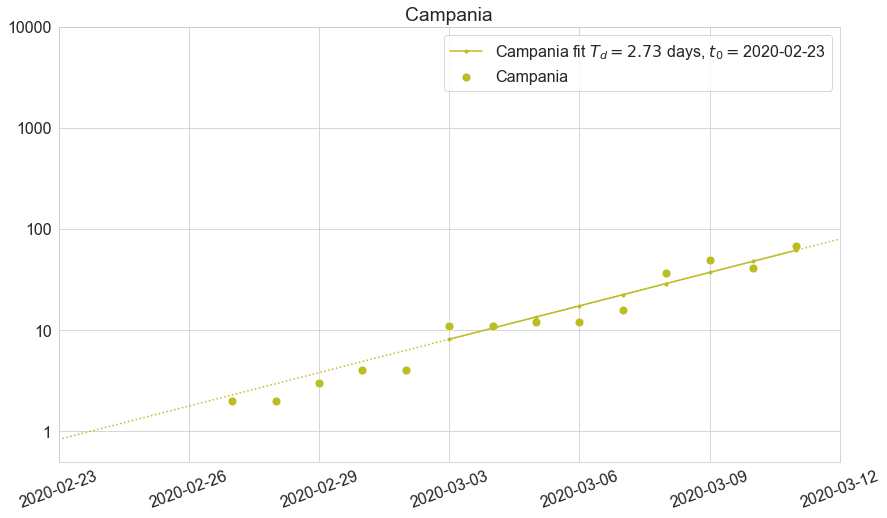

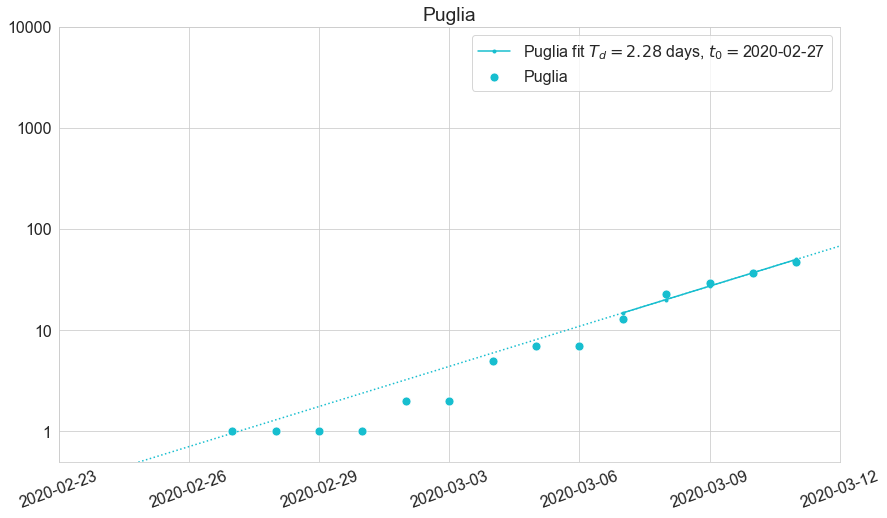

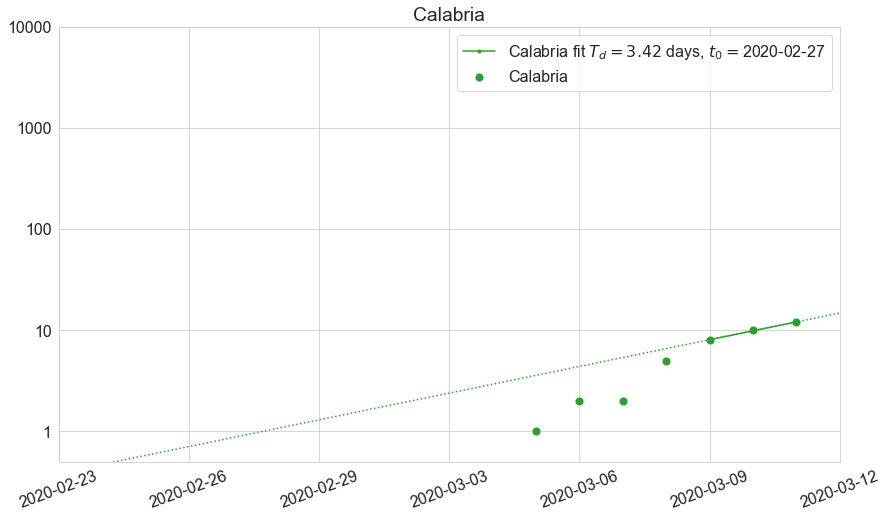

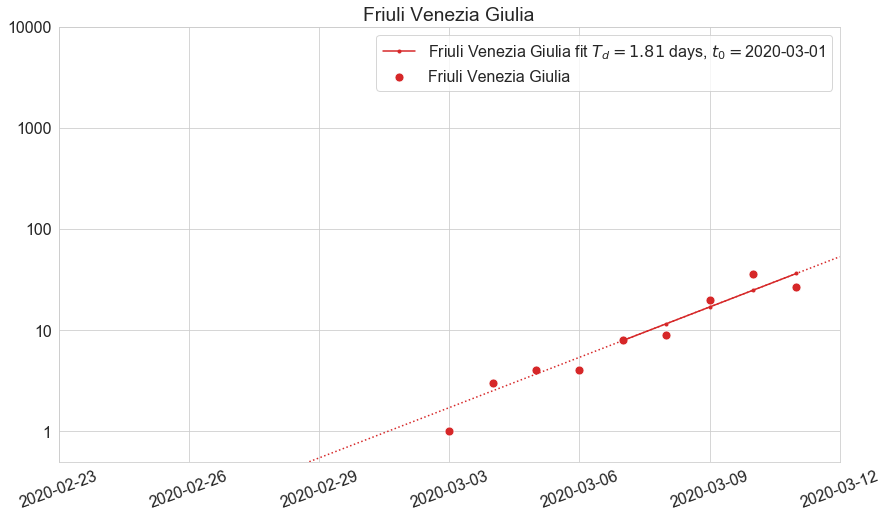

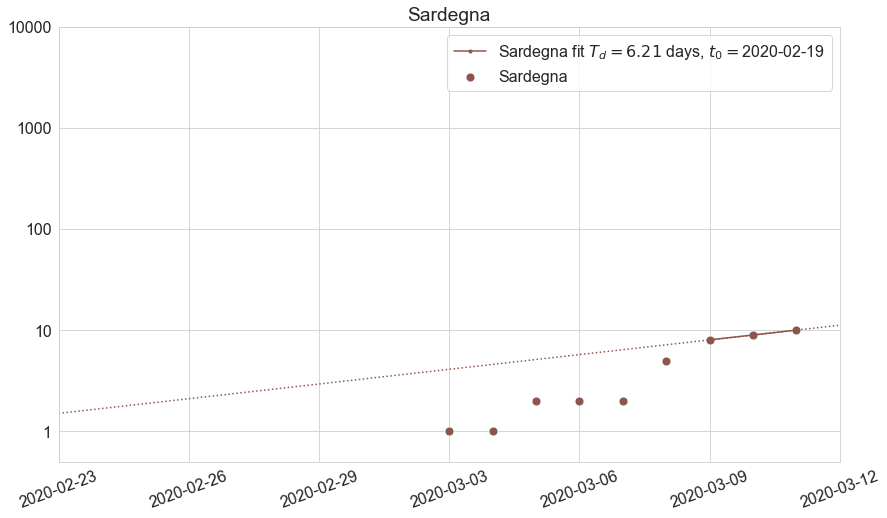

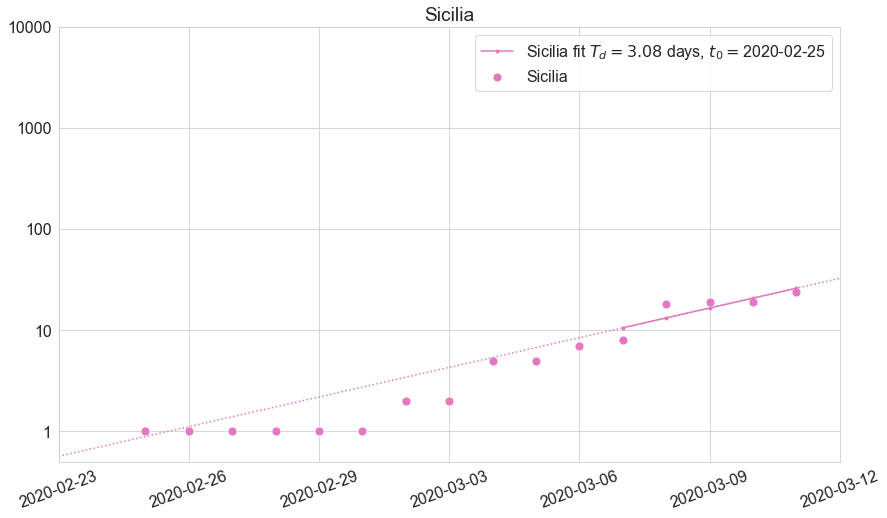

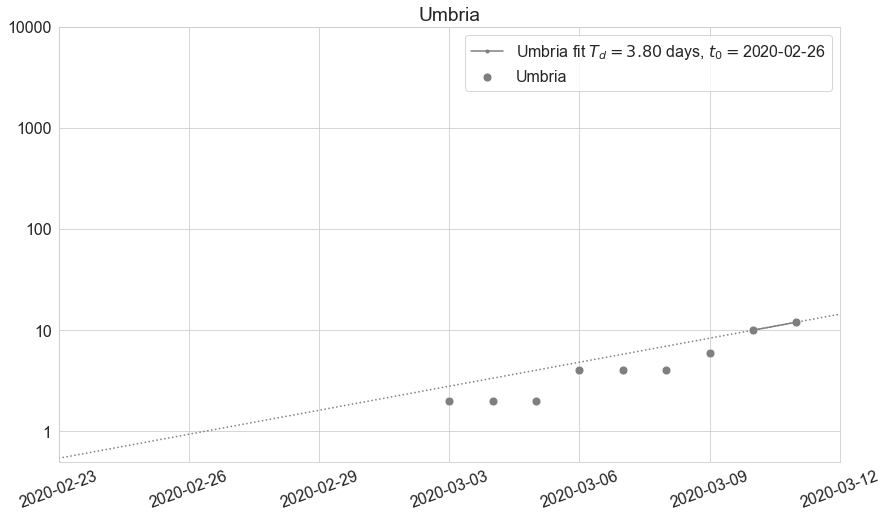

In [8]:
for region, color in zip(REGIONS_FIT_PARAMS, PALETTE):
    for kind in ['totale_ricoverati']:
        if len(fits[region, kind]) == 0:
            print('No data for', region)
            continue
        _, ax = plt.subplots(subplot_kw={'yscale': 'log', 'ylim': (0.5, 10000)})
        select = (data_italy_regions['denominazione_regione'] == region)
        try:
            for fit in fits[region, kind]:
                covid19.plot.plot_fit(ax, fit, label=region, extrapolate=EXTRAPOLTATE, color=color)
            covid19.plot.plot_data(ax, data_italy_regions[select][kind], label=region, color=color, date_interval=3)
            ax.set_title(region)
        except:
            pass

#_ = ax.set(title=r'COVID-19 "severe" cases in Italy. Fit is $f(t) = 2 ^ \frac{t - t_0}{T_d}$, with $T_d$ doubling time and $t_0$ reference date')


## Estimate of the initial / uncontined doubling time

In [9]:
for key, value in list(fits.items())[:10]:
    if len(value):
        print(f'{key[0]} {" " * (15 - len(key[0]))} {str(value[0])}')

Lombardia        T_d_days=2.40, t_0='2020-02-08T12:23:13', start=2020-02-24, stop=2020-03-06
Emilia Romagna   T_d_days=1.61, t_0='2020-02-18T09:10:37', start=2020-02-24, stop=2020-03-01
Veneto           T_d_days=3.43, t_0='2020-02-10T04:28:48', start=2020-02-24, stop=2020-03-06
Piemonte         T_d_days=1.47, t_0='2020-02-25T06:12:12', start=2020-03-01, stop=2020-03-08
Marche           T_d_days=1.57, t_0='2020-02-23T21:31:54', start=2020-02-29, stop=2020-03-05
Toscana          T_d_days=1.56, t_0='2020-02-26T16:08:29', start=2020-03-03, stop=2020-03-08
Liguria          T_d_days=2.07, t_0='2020-02-25T08:42:21', start=2020-03-04, stop=2020-03-11
Lazio            T_d_days=1.66, t_0='2020-02-26T06:26:34', start=2020-03-03, stop=2020-03-06
Campania         T_d_days=2.73, t_0='2020-02-23T17:35:23', start=2020-03-03, stop=2020-03-11
Puglia           T_d_days=2.28, t_0='2020-02-27T03:31:03', start=2020-03-07, stop=2020-03-11
